In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [2]:
#import data
df = pd.read_csv('EURUSDdata.csv')
df.head()

,Date,Time,Open,High,Low,Close,Volume
0,2008.03.30,0:00,1.5812,1.5895,1.5510,1.5733,114257
1,2008.03.31,0:00,1.5812,1.5895,1.5759,1.5786,22207
2,2008.04.01,0:00,1.5785,1.5786,1.5563,1.5613,23975
3,2008.04.02,0:00,1.5613,1.5701,1.5532,1.5684,23025
4,2008.04.03,0:00,1.5685,1.5696,1.5510,1.5682,22181


In [3]:
#filter column
dataset = df[['Open', 'High', 'Low', 'Close']]
dataset.head()

,Open,High,Low,Close
0,1.5812,1.5895,1.5510,1.5733
1,1.5812,1.5895,1.5759,1.5786
2,1.5785,1.5786,1.5563,1.5613
3,1.5613,1.5701,1.5532,1.5684
4,1.5685,1.5696,1.5510,1.5682


In [4]:
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(dataset)
data = pd.DataFrame(data=norm_data, columns=['Open', 'High', 'Low', 'Close'])
data.head()

,Open,High,Low,Close
0,0.968242,0.974561,0.935750,0.954318
1,0.968242,0.974561,0.980816,0.963775
2,0.963424,0.955170,0.945342,0.932904
3,0.932736,0.940048,0.939732,0.945574
4,0.945582,0.939159,0.935750,0.945217


In [5]:
def load_data(data, seq_len):
    amount_of_features = len(data.columns)
    dataset = data.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(dataset) - sequence_length):
        result.append(dataset[index: index + sequence_length])

    result = np.array(result)
    days = round(0.9 * result.shape[0])     #split data training 
    train = result[:int(days), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(days):, :-1]
    y_test = result[int(days):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    
    return [x_train, y_train, x_test, y_test]

In [6]:
#lstm model
def build_model2(layers):
    
   
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,init='uniform',activation='tanh'))     #tanh or relu   
    model.add(Dense(1,init='uniform',activation='tanh'))
        
    rmsprop = optimizers.RMSprop(lr=0.005)
    model.compile(loss='mse',optimizer=rmsprop, metrics=['accuracy'])
    return model

In [7]:
#initialization
window = 2
epoch = 100
test_split = 0.1
batch = 15

print('Loading data.....\n')

X_train, y_train, X_test, y_test = load_data(data, window)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


print('\nData loaded. \nTraining process...\n')

#choose model
model = build_model2([4,window,1])

#fit data into model
history = model.fit(
                    X_train,
                    y_train,
                    batch_size=batch,
                    nb_epoch=epoch,
                    validation_split=test_split,
                    verbose=0)


Loading data.....

X_train (2247, 2, 4)
y_train (2247,)
X_test (250, 2, 4)
y_test (250,)

Data loaded. 
Training process...



C:\Users\irfan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, kernel_initializer="uniform", activation="tanh")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\irfan\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", activation="tanh")`
  if sys.path[0] == '':
C:\Users\irfan\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [8]:
#training error
print('Training error:- MSE: %.4f ' % history.history['loss'][-1])
print('\t\t RMSE: %.4f ' % math.sqrt(history.history['loss'][-1]))

#testing error
print('\nTesting error:- MSE: %.4f ' % history.history['val_loss'][-1])
print('\t\tRMSE: %.4f ' % math.sqrt(history.history['val_loss'][-1]))

Training error:- MSE: 0.0005 
		 RMSE: 0.0229 

Testing error:- MSE: 0.0001 
		RMSE: 0.0118 


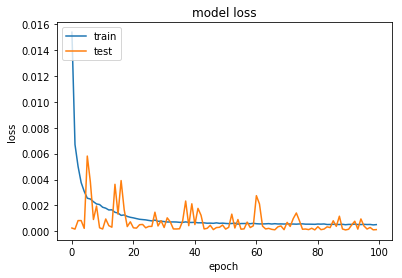

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
#print(X_test[-1])
diff=[]
ratio=[]
predict = model.predict(X_test)
print('data\t test\t\t\t prediction\t difference')
for u in range(len(y_test)):
    prediction = predict[u][0]
    ratio.append((y_test[u]/prediction)-1)
    diff.append(abs(y_test[u]- prediction))
    print(u, '\t' , y_test[u], '\t' , prediction, '\t' , '%.4f'% abs(y_test[u]- prediction))

data	 test			 prediction	 difference
0 	 0.0894734024519 	 0.0819917 	 0.0075
1 	 0.0929709666482 	 0.0823315 	 0.0106
2 	 0.090472706508 	 0.0869395 	 0.0035
3 	 0.106622173843 	 0.0869287 	 0.0197
4 	 0.105908385232 	 0.0959911 	 0.0099
5 	 0.119274076982 	 0.100827 	 0.0184
6 	 0.126840236264 	 0.110735 	 0.0161
7 	 0.128089366334 	 0.122621 	 0.0055
8 	 0.134335016685 	 0.124464 	 0.0099
9 	 0.116597369689 	 0.128337 	 0.0117
10 	 0.112778600617 	 0.12073 	 0.0080
11 	 0.093327860954 	 0.112821 	 0.0195
12 	 0.0901158122022 	 0.109605 	 0.0195
13 	 0.0845839504631 	 0.0887899 	 0.0042
14 	 0.0625635717982 	 0.0807473 	 0.0182
15 	 0.0596727279216 	 0.0620174 	 0.0023
16 	 0.0542657791895 	 0.056108 	 0.0018
17 	 0.0424525776691 	 0.0495268 	 0.0071
18 	 0.036242616749 	 0.0427292 	 0.0065
19 	 0.0429343849819 	 0.034649 	 0.0083
20 	 0.0426131801067 	 0.0388323 	 0.0038
21 	 0.0296222273774 	 0.0394614 	 0.0098
22 	 0.0289619729117 	 0.0323878 	 0.0034
23 	 0.0367244240618 	 0.0301

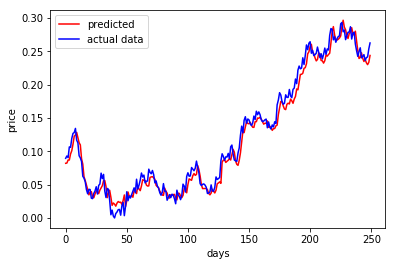

In [11]:
import matplotlib.pyplot as plt

plt.plot(predict,color='red', label='predicted')
plt.plot(y_test,color='blue', label='actual data')
plt.ylabel('price')
plt.xlabel('days')
plt.legend(loc='upper left')
plt.show()